# Estimation

In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2


<IPython.core.display.Javascript object>

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import thinkplot

<IPython.core.display.Javascript object>

## The estimation game

Let's play a game. I think of a distribution, and you have to guess what
it is. I'll give you two hints: it's a normal distribution, and here's a
random sample drawn from it:

`[-0.441, 1.774, -0.101, -1.138, 2.975, -2.138]`

What do you think is the mean parameter, $\mu$, of this distribution?

One choice is to use the sample mean, $\bar{x}$, as an estimate of $\mu$.
In this example, $\bar{x}$ is 0.155, so it would be reasonable to guess
$\mu$ = 0.155. This process is called **estimation**, and the statistic
we used (the sample mean) is called an **estimator**.

Using the sample mean to estimate $\mu$ is so obvious that it is hard to
imagine a reasonable alternative. But suppose we change the game by
introducing outliers.

*I'm thinking of a distribution.* It's a normal distribution, and here's
a sample that was collected by an unreliable surveyor who occasionally
puts the decimal point in the wrong place.

`[-0.441, 1.774, -0.101, -1.138, 2.975, -213.8]`

Now what's your estimate of $\mu$? If you use the sample mean, your
guess is -35.12. Is that the best choice? What are the alternatives?

One option is to identify and discard outliers, then compute the sample
mean of the rest. Another option is to use the median as an estimator.

Which estimator is best depends on the circumstances (for example,
whether there are outliers) and on what the goal is. Are you trying to
minimize errors, or maximize your chance of getting the right answer?

If there are no outliers, the sample mean minimizes the **mean squared
error** (MSE). That is, if we play the game many times, and each time
compute the error $\bar{x} - \mu$, the sample mean minimizes

$$MSE = \frac{1}{m} \sum (\bar{x} - \mu)^2$$

Where $m$ is the number of
times you play the estimation game, not to be confused with $n$, which
is the size of the sample used to compute $\bar{x}$.

The following function takes a sequence of estimates and the actual value, and returns the square root of the mean squared error (RMSE).

In [4]:
def rmse(estimates, actual):
    """Computes the root mean squared error of a sequence of estimates.

    estimate: sequence of numbers
    actual: actual value

    returns: float RMSE
    """
    e2 = [((estimate - actual) ** 2) for estimate in estimates]
    mse = np.mean(e2)
    return np.sqrt(mse)

<IPython.core.display.Javascript object>

Now here is a function that simulates the estimation game. Each time through the loop, it generates a random sample, computes the sample mean and median, and collects them in lists.
The it computes the RMSE of the estimates.

In practice, of course, we don't know `actual`.
If we did, we wouldn't have to estimate it.
The purpose of this experiment is to
compare the performance of the two estimators.

In [5]:
np.random.seed(17)

<IPython.core.display.Javascript object>

In [6]:
import random

n = 10
iters = 1001

mu = 0
sigma = 1
means = []
medians = []
for _ in range(iters):
    xs = [random.gauss(mu, sigma) for i in range(n)]
    xbar = np.mean(xs)
    m = np.median(xs)
    means.append(xbar)
    medians.append(m)

print("rmse xbar", rmse(means, mu))
print("rmse m", rmse(medians, mu))

rmse xbar 0.3185879288482691
rmse m 0.3800841479922768


<IPython.core.display.Javascript object>

Again, `n` is the size of the sample, and `m` is the number of times we
play the game.

The results depend on random numbers, so they vary from one run to the next.
But most often we expect the sample mean to yield a lower RMSE than the sample median.

Minimizing MSE is a nice property, but it's not always the best
strategy. For example, suppose we are estimating the distribution of
wind speeds at a building site. If the estimate is too high, we might
overbuild the structure, increasing its cost. But if it's too low, the
building might collapse. Because cost as a function of error is not
symmetric, minimizing MSE is not the best strategy.

As another example, suppose I roll three six-sided dice and ask you to
predict the total. If you get it exactly right, you get a prize;
otherwise you get nothing. In this case the value that minimizes MSE is
10.5, but that would be a bad guess, because the total of three dice is
never 10.5. For this game, you want an estimator that has the highest
chance of being right, which is a **maximum likelihood estimator**
(MLE). If you pick 10 or 11, your chance of winning is 1 in 8, and
that's the best you can do.

## Guess the variance

*I'm thinking of a distribution.* It's a normal distribution, and here's
a (familiar) sample:

`[-0.441, 1.774, -0.101, -1.138, 2.975, -2.138]`

What do you think is the variance, $\sigma^2$, of my distribution?
Again, the obvious choice is to use the sample variance, $S^2$, as an
estimator. 

$$S^2 = \frac{1}{n} \sum (x_i - \bar{x})^2$$ 

For large samples,
$S^2$ is an adequate estimator, but for small samples it tends to be too
low. Because of this unfortunate property, it is called a **biased**
estimator. An estimator is **unbiased** if the expected total (or mean)
error, after many iterations of the estimation game, is 0.

Fortunately, there is another simple statistic that is an unbiased
estimator of $\sigma^2$:

$$S_{n-1}^2 = \frac{1}{n-1} \sum (x_i - \bar{x})^2$$

For an explanation of why $S^2$ is biased, and a proof that $S_{n-1}^2$ is unbiased, see
<http://wikipedia.org/wiki/Bias_of_an_estimator>.

In [10]:
def var(xs, correction=0):
    """Computes variance.

    xs: sequence of values
    ddof: delta degrees of freedom

    returns: float
    """
    xs = np.asarray(xs)
    mu = xs.mean()
    ds = xs - mu
    n = len(xs)
    return np.sum(ds**2) / (n - correction)

<IPython.core.display.Javascript object>

In [11]:
# TODO: Test RMSE and then check for bias

<IPython.core.display.Javascript object>

`mean_error` computes the mean difference between the estimates and the
actual value:

In [12]:
def mean_error(estimates, actual):
    """Computes the mean error of a sequence of estimates.

    estimate: sequence of numbers
    actual: actual value

    returns: float mean error
    """
    errors = [(estimate - actual) for estimate in estimates]
    return np.mean(errors)

<IPython.core.display.Javascript object>

Here is a function that simulates the estimation game and tests the
performance of $S^2$ and $S_{n-1}^2$:

In [13]:
mu = 0
sigma = 1
estimates1 = []
estimates2 = []
for _ in range(iters):
    xs = [random.gauss(mu, sigma) for i in range(n)]
    biased = var(xs)
    unbiased = var(xs, correction=1)
    estimates1.append(biased)
    estimates2.append(unbiased)

print("mean error biased", mean_error(estimates1, sigma**2))
print("mean error unbiased", mean_error(estimates2, sigma**2))

mean error biased -0.09526372618941478
mean error unbiased 0.005262526456205795


<IPython.core.display.Javascript object>

Again, `n` is the sample size and `m` is the number of times we play the
game. 

When I ran this code, the mean error for $S^2$ was -0.13. As expected,
this biased estimator tends to be too low. For $S_{n-1}^2$, the mean
error was 0.014, about 10 times smaller. As `m` increases, we expect the
mean error for $S_{n-1}^2$ to approach 0.

Properties like MSE and bias are long-term expectations based on many
iterations of the estimation game. By running simulations like the ones
in this chapter, we can compare estimators and check whether they have
desired properties.

But when you apply an estimator to real data, you just get one estimate.
It would not be meaningful to say that the estimate is unbiased; being
unbiased is a property of the estimator, not the estimate.

After you choose an estimator with appropriate properties, and use it to
generate an estimate, the next step is to characterize the uncertainty
of the estimate, which is the topic of the next section.

## Sampling distributions

Suppose you are a scientist studying gorillas in a wildlife preserve.
You want to know the average weight of the adult female gorillas in the
preserve. To weigh them, you have to tranquilize them, which is
dangerous, expensive, and possibly harmful to the gorillas. But if it is
important to obtain this information, it might be acceptable to weigh a
sample of 9 gorillas. Let's assume that the population of the preserve
is well known, so we can choose a representative sample of adult
females. We could use the sample mean, $\bar{x}$, to estimate the unknown
population mean, $\mu$.

Having weighed 9 female gorillas, you might find $\bar{x}=90$ kg and
sample standard deviation, $S=7.5$ kg. The sample mean is an unbiased
estimator of $\mu$, and in the long run it minimizes MSE. So if you
report a single estimate that summarizes the results, you would report
90 kg.

But how confident should you be in this estimate? If you only weigh
$n=9$ gorillas out of a much larger population, you might be unlucky and
choose the 9 heaviest gorillas (or the 9 lightest ones) just by chance.
Variation in the estimate caused by random selection is called
**sampling error**.

To quantify sampling error, we can simulate the sampling process with
hypothetical values of $\mu$ and $\sigma$, and see how much $\bar{x}$
varies.

Since we don't know the actual values of $\mu$ and $\sigma$ in the
population, we'll use the estimates $\bar{x}$ and $S$. So the question we
answer is: "If the actual values of $\mu$ and $\sigma$ were 90 kg and
7.5 kg, and we ran the same experiment many times, how much would the
estimated mean, $\bar{x}$, vary?"

The following function answers that question:

In [14]:
def simulate_sample(mu=90, sigma=7.5, n=9, iters=1000):
    xbars = []
    for j in range(iters):
        xs = np.random.normal(mu, sigma, n)
        xbar = np.mean(xs)
        xbars.append(xbar)
    return xbars

<IPython.core.display.Javascript object>

`mu` and `sigma` are the *hypothetical* values of the parameters. `n` is
the sample size, the number of gorillas we measured. `m` is the number
of times we run the simulation.

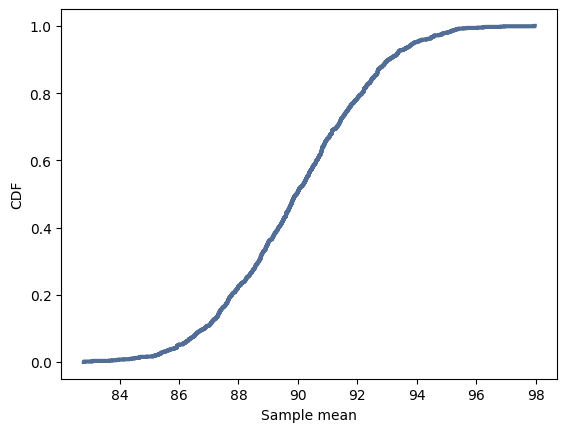

<IPython.core.display.Javascript object>

In [15]:
from thinkstats import Cdf

xbars = simulate_sample()
cdf = Cdf(xbars)
thinkplot.cdf(cdf)
thinkplot.config(xlabel="Sample mean", ylabel="CDF")

In each iteration, we choose `n` values from a normal distribution with
the given parameters, and compute the sample mean, `xbar`. We run 1000
simulations and then compute the distribution, `cdf`, of the estimates.
The result is shown in
Figure [\[estimation1\]](#estimation1){reference-type="ref"
reference="estimation1"}. This distribution is called the **sampling
distribution** of the estimator. It shows how much the estimates would
vary if we ran the experiment over and over.

The mean of the sampling distribution is pretty close to the
hypothetical value of $\mu$, which means that the experiment yields the
right answer, on average. After 1000 tries, the lowest result is 82 kg,
and the highest is 98 kg. This range suggests that the estimate might be
off by as much as 8 kg.

In [16]:
np.mean(xbars)

89.97975274187043

<IPython.core.display.Javascript object>

In [17]:
ci = cdf.percentile(5), cdf.percentile(95)
ci

(85.9691665035386, 93.89352504314084)

<IPython.core.display.Javascript object>

In [18]:
stderr = rmse(xbars, 90)
stderr

2.4328629138051032

<IPython.core.display.Javascript object>

There are two common ways to summarize the sampling distribution:

-   **Standard error** (SE) is a measure of how far we expect the
    estimate to be off, on average. For each simulated experiment, we
    compute the error, $\bar{x} - \mu$, and then compute the root mean
    squared error (RMSE). In this example, it is roughly 2.5 kg.

-   A **confidence interval** (CI) is a range that includes a given
    fraction of the sampling distribution. For example, the 90%
    confidence interval is the range from the 5th to the 95th
    percentile. In this example, the 90% CI is $(86, 94)$ kg.

Standard errors and confidence intervals are the source of much
confusion:

-   People often confuse standard error and standard deviation. Remember
    that standard deviation describes variability in a measured
    quantity; in this example, the standard deviation of gorilla weight
    is 7.5 kg. Standard error describes variability in an estimate. In
    this example, the standard error of the mean, based on a sample of 9
    measurements, is 2.5 kg.

One way to remember the difference is that, as sample size
increases, standard error gets smaller; standard deviation does not.

-   People often think that there is a 90% probability that the actual
    parameter, $\mu$, falls in the 90% confidence interval. Sadly, that
    is not true. If you want to make a claim like that, you have to use
    Bayesian methods (see my book, *Think Bayes*).

The sampling distribution answers a different question: it gives you
a sense of how reliable an estimate is by telling you how much it
would vary if you ran the experiment again.

It is important to remember that confidence intervals and standard
errors only quantify sampling error; that is, error due to measuring
only part of the population. The sampling distribution does not account
for other sources of error, notably sampling bias and measurement error,
which are the topics of the next section.

## Sampling bias

Suppose that instead of the weight of gorillas in a nature preserve, you
want to know the average weight of women in the city where you live. It
is unlikely that you would be allowed to choose a representative sample
of women and weigh them.

A simple alternative would be "telephone sampling;" that is, you could
choose random numbers from the phone book, call and ask to speak to an
adult woman, and ask how much she weighs.

Telephone sampling has obvious limitations. For example, the sample is
limited to people whose telephone numbers are listed, so it eliminates
people without phones (who might be poorer than average) and people with
unlisted numbers (who might be richer). Also, if you call home
telephones during the day, you are less likely to sample people with
jobs. And if you only sample the person who answers the phone, you are
less likely to sample people who share a phone line.

If factors like income, employment, and household size are related to
weight---and it is plausible that they are---the results of your survey
would be affected one way or another. This problem is called **sampling
bias** because it is a property of the sampling process.

This sampling process is also vulnerable to self-selection, which is a
kind of sampling bias. Some people will refuse to answer the question,
and if the tendency to refuse is related to weight, that would affect
the results.

Finally, if you ask people how much they weigh, rather than weighing
them, the results might not be accurate. Even helpful respondents might
round up or down if they are uncomfortable with their actual weight. And
not all respondents are helpful. These inaccuracies are examples of
**measurement error**.

When you report an estimated quantity, it is useful to report standard
error, or a confidence interval, or both, in order to quantify sampling
error. But it is also important to remember that sampling error is only
one source of error, and often it is not the biggest.

## Exponential distributions

Let's play one more round of the estimation game. *I'm thinking of a
distribution.* It's an exponential distribution, and here's a sample:

`[5.384, 4.493, 19.198, 2.790, 6.122, 12.844]`

What do you think is the parameter, $\lambda$, of this distribution?

In general, the mean of an exponential distribution is $1/\lambda$, so
working backwards, we might choose 

$$L= 1 / \bar{x}$$

$L$ is an estimator
of $\lambda$. And not just any estimator; it is also the maximum
likelihood estimator (see
<http://wikipedia.org/wiki/Exponential_distribution#Maximum_likelihood>).
So if you want to maximize your chance of guessing $\lambda$ exactly,
$L$ is the way to go.

But we know that $\bar{x}$ is not robust in the presence of outliers, so
we expect $L$ to have the same problem.

We can choose an alternative based on the sample median. The median of
an exponential distribution is $\ln(2) / \lambda$, so working backwards
again, we can define an estimator $$L_m= \ln(2) / m$$ where $m$ is the
sample median.

To test the performance of these estimators, we can simulate the
sampling process:

In [22]:
def median(seq):
    n = len(seq)
    t = sorted(seq)
    i = (n - 1) // 2
    return t[i]

<IPython.core.display.Javascript object>

In [23]:
lam = 2
ls = []
lms = []

for _ in range(iters):
    xs = np.random.exponential(1.0 / lam, n)
    L = 1 / np.mean(xs)
    Lm = np.log(2) / median(xs)
    ls.append(L)
    lms.append(Lm)

<IPython.core.display.Javascript object>

In [24]:
print("rmse L", rmse(ls, lam))
print("rmse Lm", rmse(lms, lam))

rmse L 0.8559468453901456
rmse Lm 1.7533117323615917


<IPython.core.display.Javascript object>

When I run this experiment with $\lambda=2$, the RMSE of $L$ is 1.1. For
the median-based estimator $L_m$, RMSE is 1.8. We can't tell from this
experiment whether $L$ minimizes MSE, but at least it seems better than
$L_m$.

In [25]:
print("mean error L", mean_error(ls, lam))
print("mean error Lm", mean_error(lms, lam))

mean error L 0.25357993651390454
mean error Lm 0.7159748009929293


<IPython.core.display.Javascript object>

Sadly, it seems that both estimators are biased. For $L$ the mean error
is 0.33; for $L_m$ it is 0.45. And neither converges to 0 as `m`
increases.

It turns out that $\bar{x}$ is an unbiased estimator of the mean of the
distribution, but $L$ is not an unbiased estimator of
$\lambda$.

## Glossary

-   **estimation**: The process of inferring the parameters of a
    distribution from a sample.

-   **estimator**: A statistic used to estimate a parameter.

-   **mean squared error (MSE)**: A measure of estimation error.

-   **root mean squared error (RMSE)**: The square root of MSE, a more
    meaningful representation of typical error magnitude.

-   **maximum likelihood estimator (MLE)**: An estimator that computes
    the point estimate most likely to be correct.

-   **bias (of an estimator)**: The tendency of an estimator to be above
    or below the actual value of the parameter, when averaged over
    repeated experiments.

-   **sampling error**: Error in an estimate due to the limited size of
    the sample and variation due to chance.

-   **sampling bias**: Error in an estimate due to a sampling process
    that is not representative of the population.

-   **measurement error**: Error in an estimate due to inaccuracy
    collecting or recording data.

-   **sampling distribution**: The distribution of a statistic if an
    experiment is repeated many times.

-   **standard error**: The RMSE of an estimate, which quantifies
    variability due to sampling error (but not other sources of error).

-   **confidence interval**: An interval that represents the expected
    range of an estimator if an experiment is repeated many times.

## Exercises

**Exercise:** Suppose you draw a sample with size n=10 from an exponential distribution with λ=2. Simulate this experiment 1000 times and plot the sampling distribution of the estimate L. Compute the standard error of the estimate and the 90% confidence interval.

Repeat the experiment with a few different values of `n` and make a plot of standard error versus `n`.



In [27]:
# Solution

lam = 2
estimates = []
for _ in range(iters):
    xs = np.random.exponential(1.0 / lam, n)
    lamhat = 1.0 / np.mean(xs)
    estimates.append(lamhat)
stderr = rmse(estimates, lam)
print("standard error", stderr)

standard error 0.87544835701183


<IPython.core.display.Javascript object>

In [28]:
# Solution

cdf = Cdf(estimates)
ci = cdf.percentile(5), cdf.percentile(95)
print("confidence interval", ci)

confidence interval (1.2378560961240366, 3.757325289859341)


<IPython.core.display.Javascript object>

In [29]:
# Solution


def vert_line(x, y=1):
    thinkplot.plot([x, x], [0, y], color="gray")

<IPython.core.display.Javascript object>

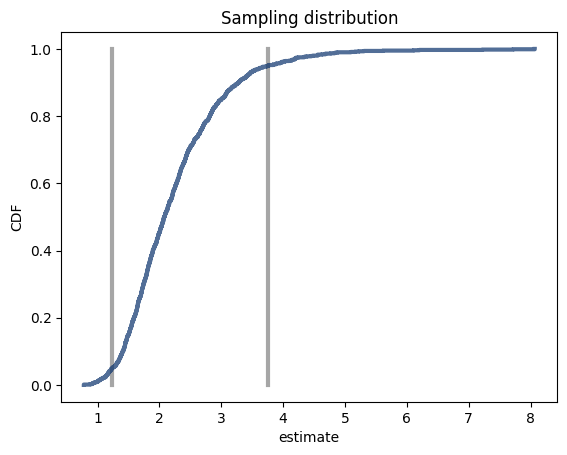

<IPython.core.display.Javascript object>

In [30]:
# Solution

vert_line(ci[0])
vert_line(ci[1])
thinkplot.cdf(cdf)
thinkplot.config(xlabel="estimate", ylabel="CDF", title="Sampling distribution")

**Exercise:** In games like hockey and soccer, the time between goals is roughly exponential. So you could estimate a team's goal-scoring rate by observing the number of goals they score in a game. This estimation process is a little different from sampling the time between goals, so let's see how it works.

Write a function that takes a goal-scoring rate, `lam`, in goals per game, and simulates a game by generating the time between goals until the total time exceeds 1 game, then returns the number of goals scored.

Write another function that simulates many games, stores the estimates of `lam`, then computes their mean error and RMSE.

Is this way of making an estimate biased?

In [31]:
def simulate_game(lam):
    """Simulates a game and returns the estimated goal-scoring rate.

    lam: actual goal scoring rate in goals per game
    """
    goals = 0
    t = 0
    while True:
        time_between_goals = random.expovariate(lam)
        t += time_between_goals
        if t > 1:
            break
        goals += 1
    L = goals
    return L

<IPython.core.display.Javascript object>

In [32]:
# Solution

lam = 2

estimates = []
for i in range(iters):
    L = simulate_game(lam)
    estimates.append(L)
print("Experiment 4")
print("rmse L", rmse(estimates, lam))
print("mean error L", mean_error(estimates, lam))

Experiment 4
rmse L 1.4408067448218294
mean error L 0.07992007992007992


<IPython.core.display.Javascript object>

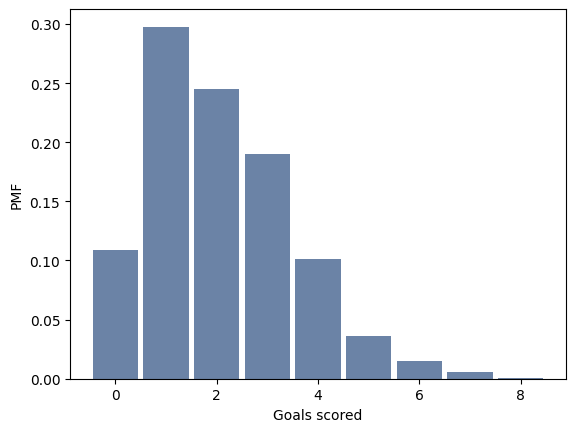

<IPython.core.display.Javascript object>

In [33]:
# Solution

from thinkstats import Pmf

pmf = Pmf(estimates)
thinkplot.hist(pmf)
thinkplot.config(xlabel="Goals scored", ylabel="PMF")

**Exercise:**  In this chapter we used $\bar{x}$ and median to estimate µ, and found that $\bar{x}$ yields lower MSE. Also, we used $S^2$ and $S_{n-1}^2$ to estimate σ, and found that $S^2$ is biased and $S_{n-1}^2$ unbiased.
Run similar experiments to see if $\bar{x}$ and median are biased estimates of µ. Also check whether $S^2$ or $S_{n-1}^2$ yields a lower MSE.

In [34]:
n = 7
iters = 1001

mu = 0
sigma = 1
means = []
medians = []
for _ in range(iters):
    xs = [random.gauss(mu, sigma) for i in range(n)]
    xbar = np.mean(xs)
    median = np.median(xs)
    means.append(xbar)
    medians.append(median)

print("mean error xbar", mean_error(means, mu))
print("mean error median", mean_error(medians, mu))

mean error xbar 0.004702696829815507
mean error median -0.0016657173960164266


<IPython.core.display.Javascript object>

In [35]:
n = 7
iters = 1001

mu = 0
sigma = 1
estimates1 = []
estimates2 = []
for _ in range(iters):
    xs = [random.gauss(mu, sigma) for i in range(n)]
    biased = np.var(xs)
    unbiased = np.var(xs, ddof=1)
    estimates1.append(biased)
    estimates2.append(unbiased)
print("RMSE biased", rmse(estimates1, sigma**2))
print("RMSE unbiased", rmse(estimates2, sigma**2))

RMSE biased 0.5147024137584276
RMSE unbiased 0.5707361695796216


<IPython.core.display.Javascript object>